In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import os
import shutil
from tqdm import tqdm
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
import cv2
import pytesseract as pt
%matplotlib inline

In [2]:
filenames = []

size_props = {
    'height':[],
    'width':[]
}

bounding_box_props = {
    'xmin':[],
    'ymin':[],
    'xmax':[],
    'ymax':[]
}

In [3]:
annotations_path = '/Users/zhanjunwen/Downloads/Taiwan Plate.v3i.voc/labels'
for file in tqdm(os.listdir(annotations_path)):
    annotation = ET.parse(os.path.join(annotations_path, file))
    filenames.append(os.path.join(annotations_path, file))
    size = annotation.find('size')
    for name, prop_list in size_props.items():
        prop_value = size.find(name).text
        size_props[name].append(int(prop_value))
    bounding_box = annotation.find('object').find('bndbox')
    for name, prop_list in bounding_box_props.items():
        prop_value = bounding_box.find(name).text
        bounding_box_props[name].append(int(prop_value))

100%|██████████████████████████████████████| 231/231 [00:00<00:00, 10868.02it/s]


In [4]:
df = pd.DataFrame({
    'file':filenames,
    'width':size_props['width'],
    'height':size_props['height'],
    'xmin':bounding_box_props['xmin'],
    'ymin':bounding_box_props['ymin'],
    'xmax':bounding_box_props['xmax'],
    'ymax':bounding_box_props['ymax']
})

In [5]:
df.head()

file  width  height  xmin  \
0  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   236   
1  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   218   
2  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   253   
3  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   114   
4  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   184   

   ymin  xmax  ymax  
0   194   370   283  
1   328   474   426  
2   267   443   350  
3   321   288   387  
4   195   430   292

In [6]:
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']

In [7]:
df.head()

file  width  height  xmin  \
0  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   236   
1  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   218   
2  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   253   
3  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   114   
4  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...    640     640   184   

   ymin  xmax  ymax  center_x  center_y  bb_width  bb_height  
0   194   370   283  0.473438  0.372656  0.209375   0.139063  
1   328   474   426  0.540625  0.589063  0.400000   0.153125  
2   267   443   350  0.543750  0.482031  0.296875   0.129688  
3   321   288   387  0.314063  0.553125  0.271875   0.103125  
4   195   430   292  0.479687  0.380469  0.384375   0.151562

In [41]:
# Keeping important columns only
yolo_df = df[['file', 'center_x', 'center_y', 'bb_width', 'bb_height']]
# Performing 70-15-15 split
test_size = int(0.15 * len(df))

df_train, df_test = train_test_split(yolo_df, test_size=test_size)
df_train, df_val = train_test_split(df_train, test_size=test_size)

In [42]:
train_path = os.path.join('car_images3', 'train')
val_path = os.path.join('car_images3','val')
test_path = os.path.join('car_images3', 'test')
images_path = '/Users/zhanjunwen/Downloads/Taiwan Plate.v3i.voc/images'

if not os.path.exists(train_path):
    os.makedirs(train_path)
    print('Made folder for train set')

if not os.path.exists(val_path):
    os.makedirs(val_path)
    print('Made folder for val set')

if not os.path.exists(test_path):
    os.makedirs(test_path)
    print('Made folder for test set')

In [12]:
df.to_csv('/Users/zhanjunwen/Downloads/car_images3/car_row.csv',index=False)

In [43]:
df_test.to_csv('/Users/zhanjunwen/Downloads/car_images3/car_test.csv')

In [13]:
print('Moving images for train set')
for _, row  in tqdm(df_train.iterrows()):
    annotation_path = row['file']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.jpg')
    image_dst = os.path.join(train_path, f'{image_name}.jpg')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(train_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for train set')

print('Moving images for val set')
for _, row  in tqdm(df_val.iterrows()):
    annotation_path = row['file']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.jpg')
    image_dst = os.path.join(val_path, f'{image_name}.jpg')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(val_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for val set')

print('Moving images for test set')
for _, row  in tqdm(df_test.iterrows()):
    annotation_path = row['file']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.jpg')
    image_dst = os.path.join(test_path, f'{image_name}.jpg')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(test_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for test set')

Moving images for train set


163it [00:00, 1539.38it/s]


Done moving images for train set
Moving images for val set


34it [00:00, 1816.83it/s]


Done moving images for val set
Moving images for test set


34it [00:00, 1684.24it/s]

Done moving images for test set


In [14]:
print(len(df_train), len(df_val), len(df_test))

163 34 34


In [20]:
train_path = "/Users/zhanjunwen/Downloads/Taiwan_license2.v2i.yolov8/train/images"
val_path = "/Users/zhanjunwen/Downloads/Taiwan_license2.v2i.yolov8/valid/images"

In [21]:
# creating data.yaml file which will be used to train YOLO on custom data
data = {
    'names':['License plate'],
    'nc':1,
    'train':os.path.abspath(train_path),
    'val':os.path.abspath(val_path)
}

with open('/Users/zhanjunwen/Downloads/Taiwan_license2.v2i.yolov8/data.yaml', 'w') as f:
    yaml.dump(data, f)

In [22]:
import ultralytics
ultralytics.checks()
from ultralytics import YOLO

Ultralytics YOLOv8.0.184 🚀 Python-3.9.6 torch-2.0.1 CPU (Apple M1 Pro)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 230.0/258.1 GB disk)


In [23]:
print(torch.backends.mps.is_available())

True


In [26]:
# Training the YOLO model
!yolo task=detect mode=train 
model=/Users/zhanjunwen/Downloads/Taiwan_license2.v2i.yolov8/yolov8s.pt 
data=/Users/zhanjunwen/Downloads/Taiwan_license2.v2i.yolov8/data.yaml 
epochs=50 batch=10 plots=True

100%|██████████████████████████████████████| 21.5M/21.5M [00:01<00:00, 11.3MB/s]
Ultralytics YOLOv8.0.184 🚀 Python-3.9.6 torch-2.0.1 CPU (Apple M1 Pro)
engine/trainer: task=detect, mode=train, model=/Users/zhanjunwen/Downloads/Taiwan_license2.v2i.yolov8/yolov8s.pt, data=/Users/zhanjunwen/Downloads/Taiwan_license2.v2i.yolov8/data.yaml, epochs=50, patience=50, batch=10, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=Fal

In [76]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8s.pt')  # load an official model
model = YOLO('/Users/zhanjunwen/Downloads/runs/detect/train11/weights/best.pt')  # load a custom model

# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map50  # map50

Ultralytics YOLOv8.0.184 🚀 Python-3.9.6 torch-2.0.1 CPU (Apple M1 Pro)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /Users/zhanjunwen/Downloads/car_images2/val.cache... 34 images, 0 
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all         34         34      0.885      0.905      0.954      0.798
Speed: 2.0ms preprocess, 387.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val2


0.9543443244293517

In [44]:
import torch

In [45]:
# Fetching the latest runs
yolo_path = '/Users/zhanjunwen/Downloads/runs/detect/train14/weights'
latest_run = os.listdir(yolo_path)[-1]

# Fetching the best weights
best_weights = os.path.join(yolo_path, 'best.pt')

# Loading the model with best weights trained on custom data
model = YOLO(best_weights)

In [46]:
df_test.head()

file  center_x  center_y  \
224  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...  0.447656  0.573438   
212  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...  0.578125  0.365625   
68   /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...  0.521094  0.722656   
12   /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...  0.449219  0.657813   
125  /Users/zhanjunwen/Downloads/Taiwan Plate.v3i.v...  0.423438  0.592969   

     bb_width  bb_height  
224  0.579688   0.253125  
212  0.446875   0.171875  
68   0.114062   0.101562  
12   0.582812   0.221875  
125  0.431250   0.279687

In [47]:
import cv2

In [48]:
from PIL import Image


0: 640x640 1 License plate, 104.2ms
Speed: 2.8ms preprocess, 104.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 License plate, 108.0ms
Speed: 3.0ms preprocess, 108.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 License plate, 117.7ms
Speed: 2.9ms preprocess, 117.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 License plate, 114.3ms
Speed: 3.4ms preprocess, 114.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 License plate, 115.0ms
Speed: 3.3ms preprocess, 115.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 License plate, 110.3ms
Speed: 2.9ms preprocess, 110.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 License plate, 111.8ms
Speed: 3.3ms preprocess, 111.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 License plate, 104.7ms
Speed: 2.9ms prepr

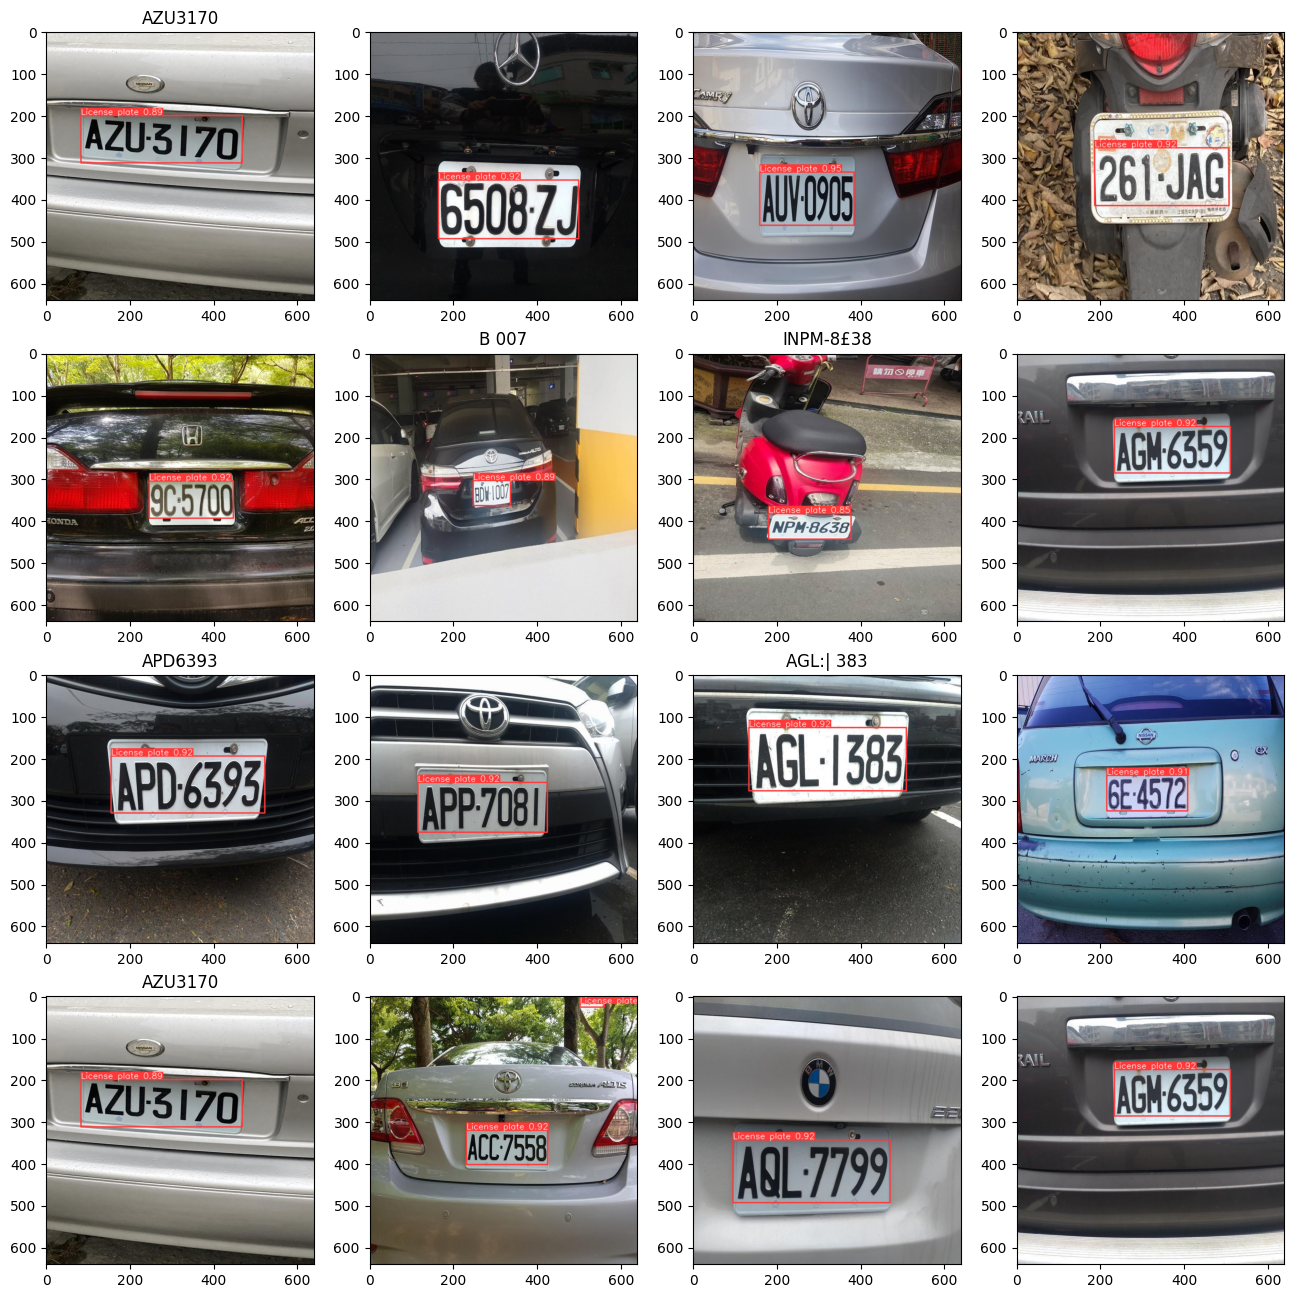

In [71]:
%matplotlib inline
# Fetching random 16 images from test set
test_files = df_test['file'].apply(lambda x: x.replace('labels','images').replace('xml','jpg'))
test_images = np.random.choice(test_files, size=(4,4))

# Visualizing predictions
fig, ax = plt.subplots(figsize=(16,16), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        # Reading the image
        image = cv2.imread(test_images[i,j]) # 
        # Convert image to RGB colorspace
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image=image[:,:,::-1].copy()
        # Predicting from model
        results=model(image[:,:,::-1], save=False, conf=0.25)

        result = results[0]
        # results = model(image)
        # Getting co ordinates of license plate
        # result = results[0]
        # box = result.boxes[0]
        # print("Object type:", box.cls)
        # print("Coordinates:", box.xyxy)
        # print("Probability:", box.conf)

        # cords = box.xyxy[0].tolist()
        # class_id = box.cls[0].item()
        # conf = box.conf[0].item()
        # print("Object type:", class_id)
        # print("Coordinates:", cords)
        # print("Probability:", conf)
        # print(result.names)

        # cords = box.xyxy[0].tolist()
        # cords = [round(x) for x in cords]
        # class_id = result.names[box.cls[0].item()]
        # conf = round(box.conf[0].item(), 2)
        # print("Object type:", class_id)
        # print("Coordinates:", cords)
        # print("Probability:", conf)
        # print("---")
        for box in result.boxes:
            # class_id = result.names[box.cls[0].item()]
            # cords = box.xyxy[0].tolist()
            # cords = [round(x) for x in cords]
            # conf = round(box.conf[0].item(), 2)
            # print("Object type:", class_id)
            # print("Coordinates:", cords)
            # print("Probability:", conf)
            cords=box.xyxy[0]
            crop = image[int(box.xyxy[0, 1]):int(box.xyxy[0, 3]), int(box.xyxy[0, 0]):int(box.xyxy[0, 2])]
            
            
            text = pt.image_to_string(crop)

            # result = cv2.cvtColor(result, cv2.COLOR_BAYER_BG2GRAY)
            
        ax[i,j].set_title(str(text).strip())
        ax[i,j].imshow(np.squeeze(result.plot()[:,:,::-1]))
        
        # Image.fromarray(np.squeeze(result.plot()))

plt.show()

In [72]:
fig.savefig('result.png')


0: 640x640 1 License plate, 104.7ms
Speed: 3.5ms preprocess, 104.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 License plate, 108.0ms
Speed: 2.9ms preprocess, 108.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 License plate, 106.3ms
Speed: 3.0ms preprocess, 106.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 License plate, 119.7ms
Speed: 3.4ms preprocess, 119.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 License plate, 112.4ms
Speed: 2.9ms preprocess, 112.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 License plate, 115.2ms
Speed: 3.0ms preprocess, 115.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 License plate, 108.6ms
Speed: 2.6ms preprocess, 108.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 License plate, 106.6ms
Speed: 2.7ms prepr

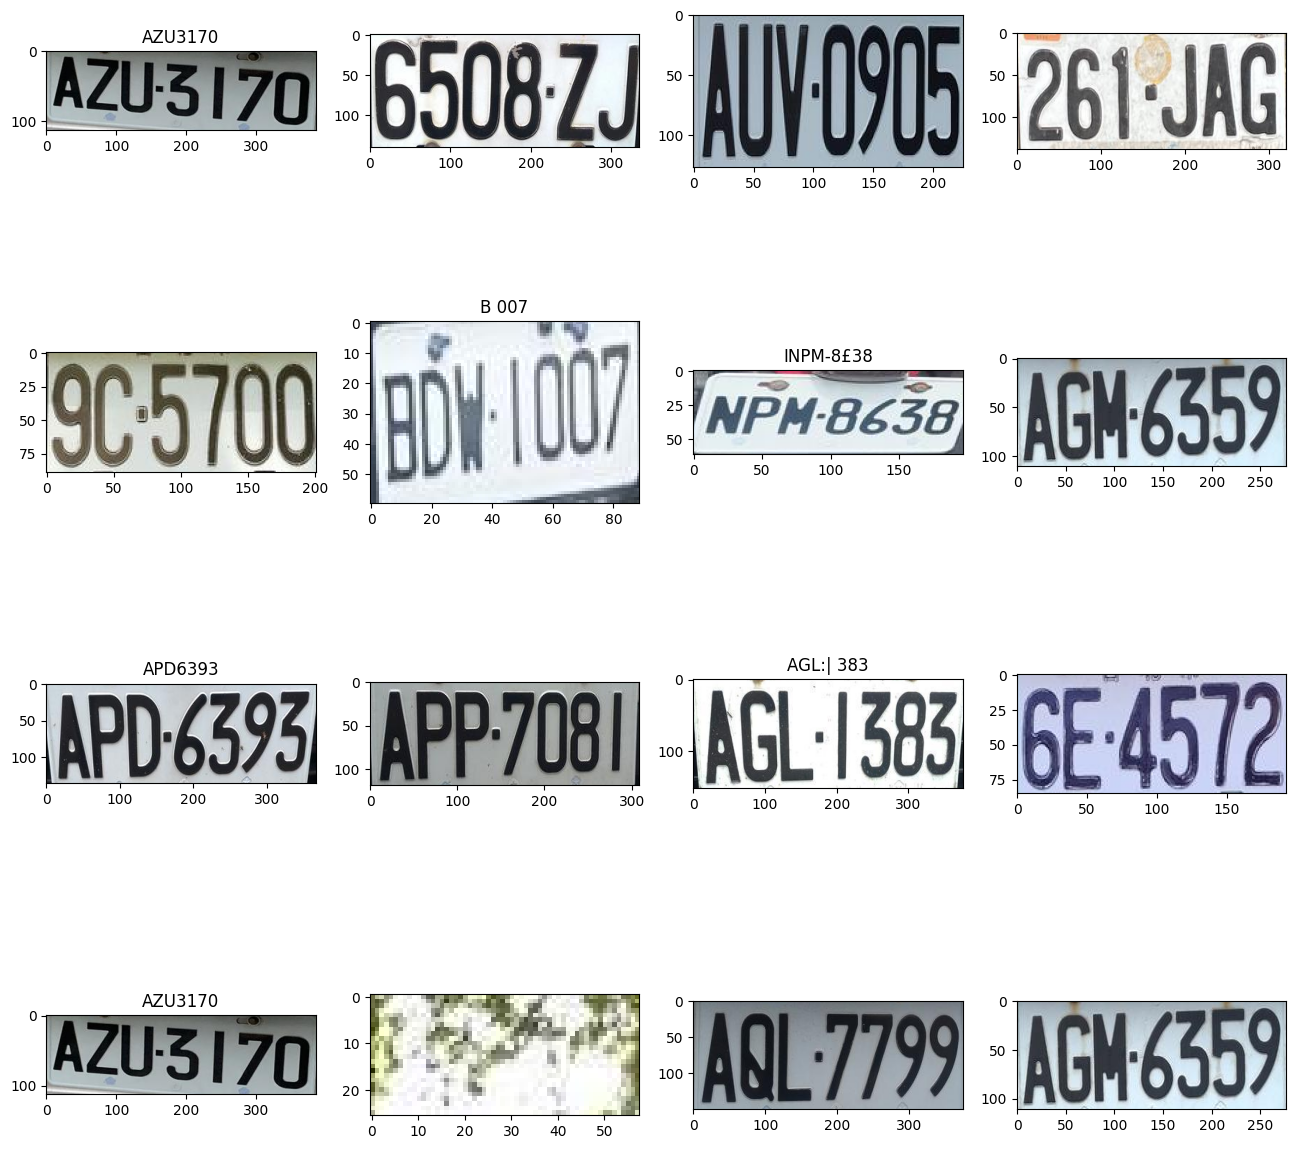

In [73]:
fig, ax = plt.subplots(figsize=(16,16), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        # Reading the image
        image = cv2.imread(test_images[i,j])
        # Convert image to RGB colorspace
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image=image[:,:,::-1].copy()
        
        # Predicting from model
        results=model(image[:,:,::-1], save=False, conf=0.25)

        result = results[0]
        for box in result.boxes:
            # class_id = result.names[box.cls[0].item()]
            # cords = box.xyxy[0].tolist()
            # cords = [round(x) for x in cords]
            # conf = round(box.conf[0].item(), 2)
            # print("Object type:", class_id)
            # print("Coordinates:", cords)
            # print("Probability:", conf)
            cords=box.xyxy[0]
            crop = image[int(box.xyxy[0, 1]):int(box.xyxy[0, 3]), int(box.xyxy[0, 0]):int(box.xyxy[0, 2])]
            text = pt.image_to_string(crop)
            
        ax[i,j].set_title(str(text).strip())
        ax[i,j].imshow(np.squeeze(crop))
        # Image.fromarray(np.squeeze(result.plot()))

plt.show()

In [74]:
fig.savefig('result1.png')

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

from yolov5 import utils
display = utils.notebook_init()

In [ ]:
!pip install -q wandb --upgrade

import wandb
wandb.login(anonymous='must')

In [ ]:
!python train.py --img 1280\
--batch 10\
--epochs 50\
--data /kaggle/working/bgr.yaml\
--weights yolov5m6.pt

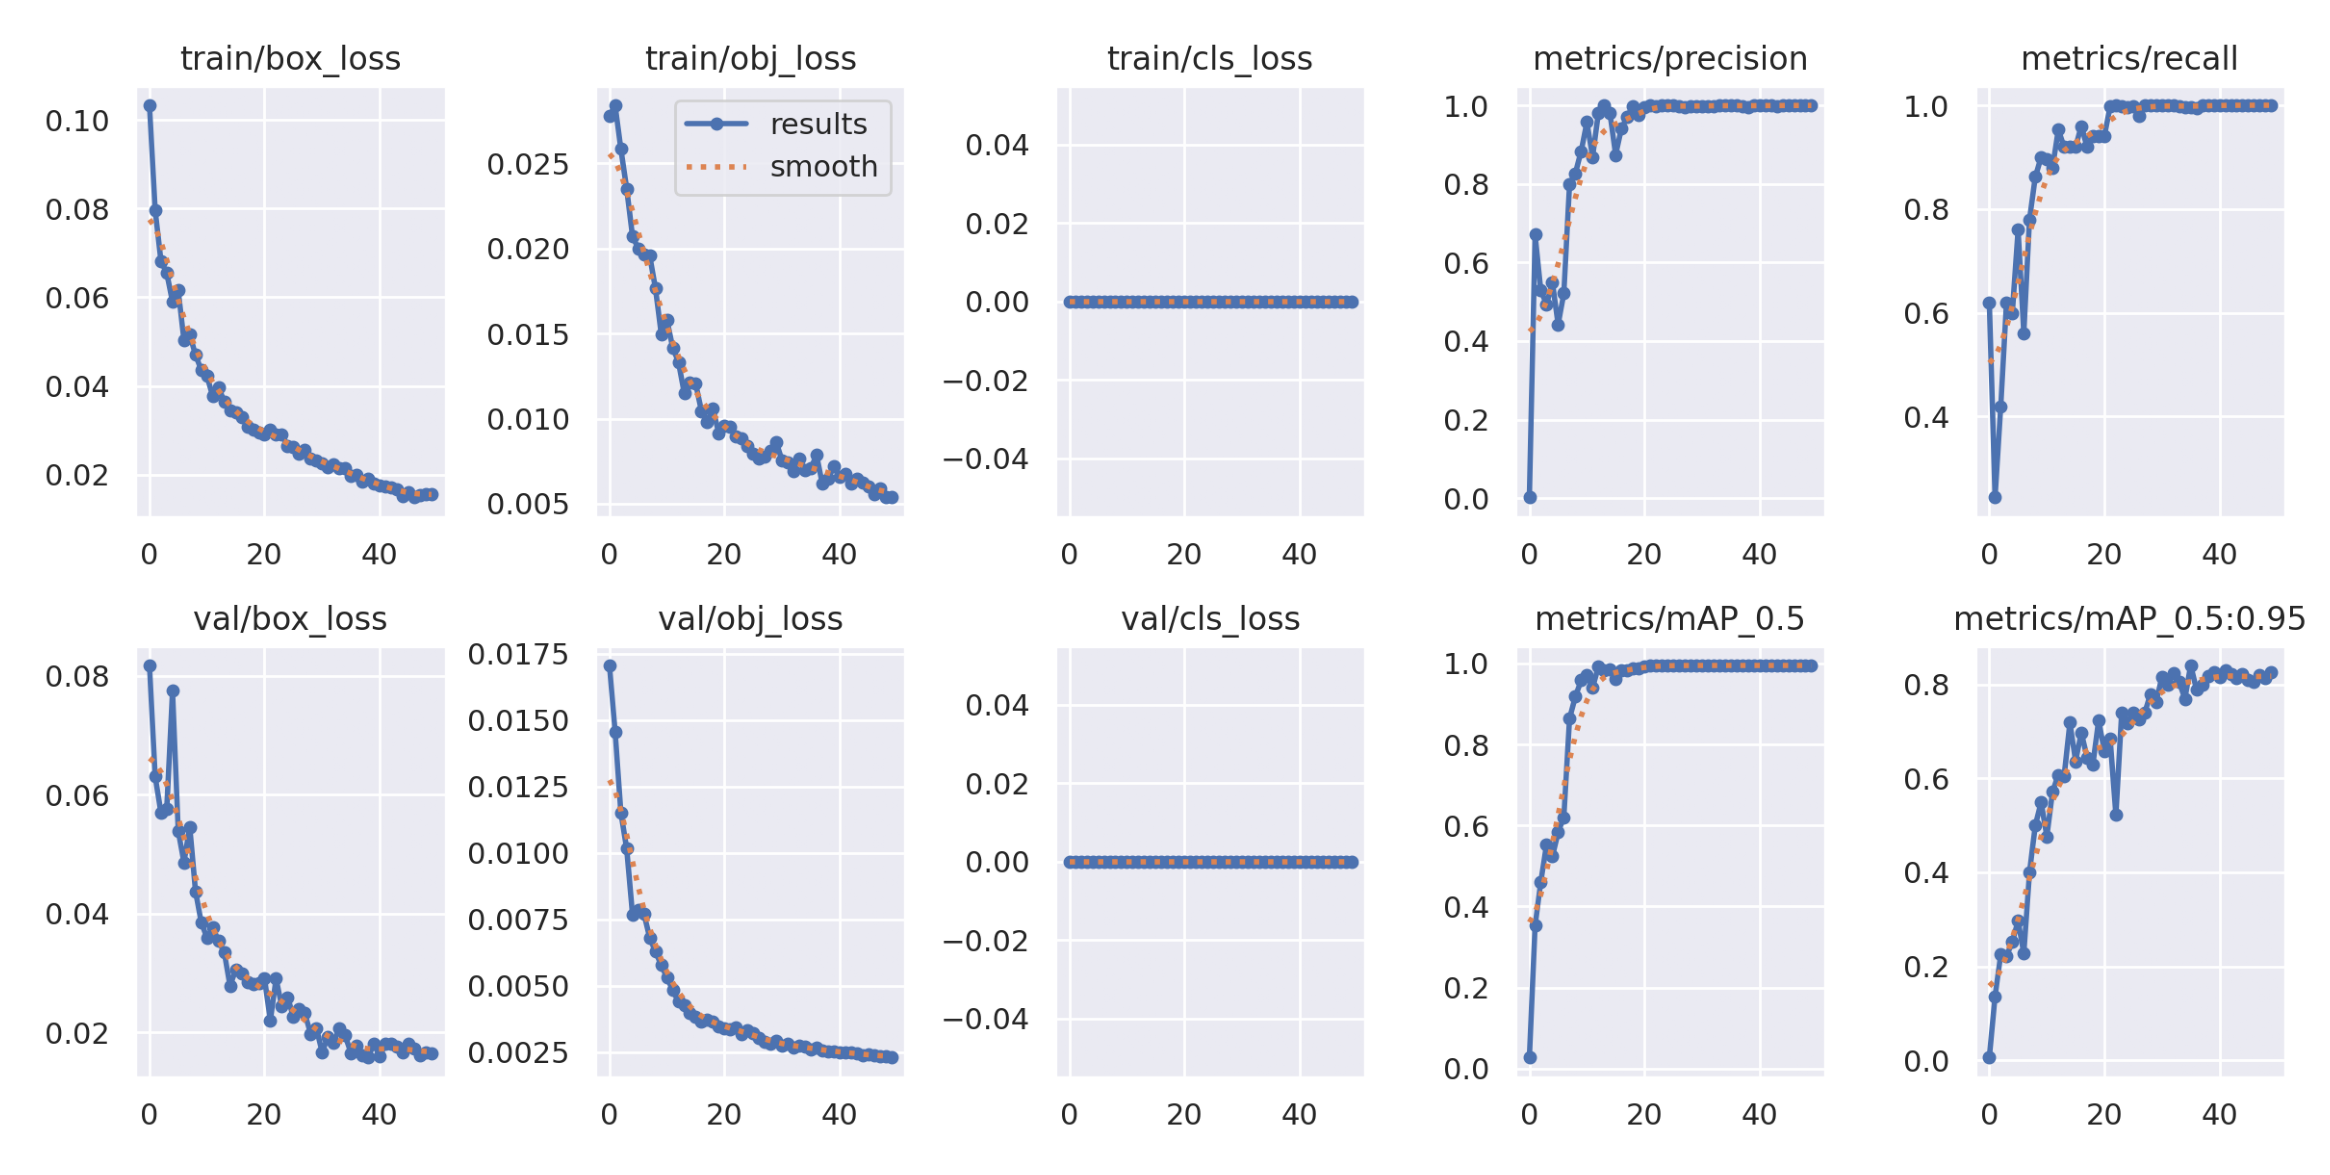

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('/content/kaggle/working/yolov5/runs/train/exp/results.png'))

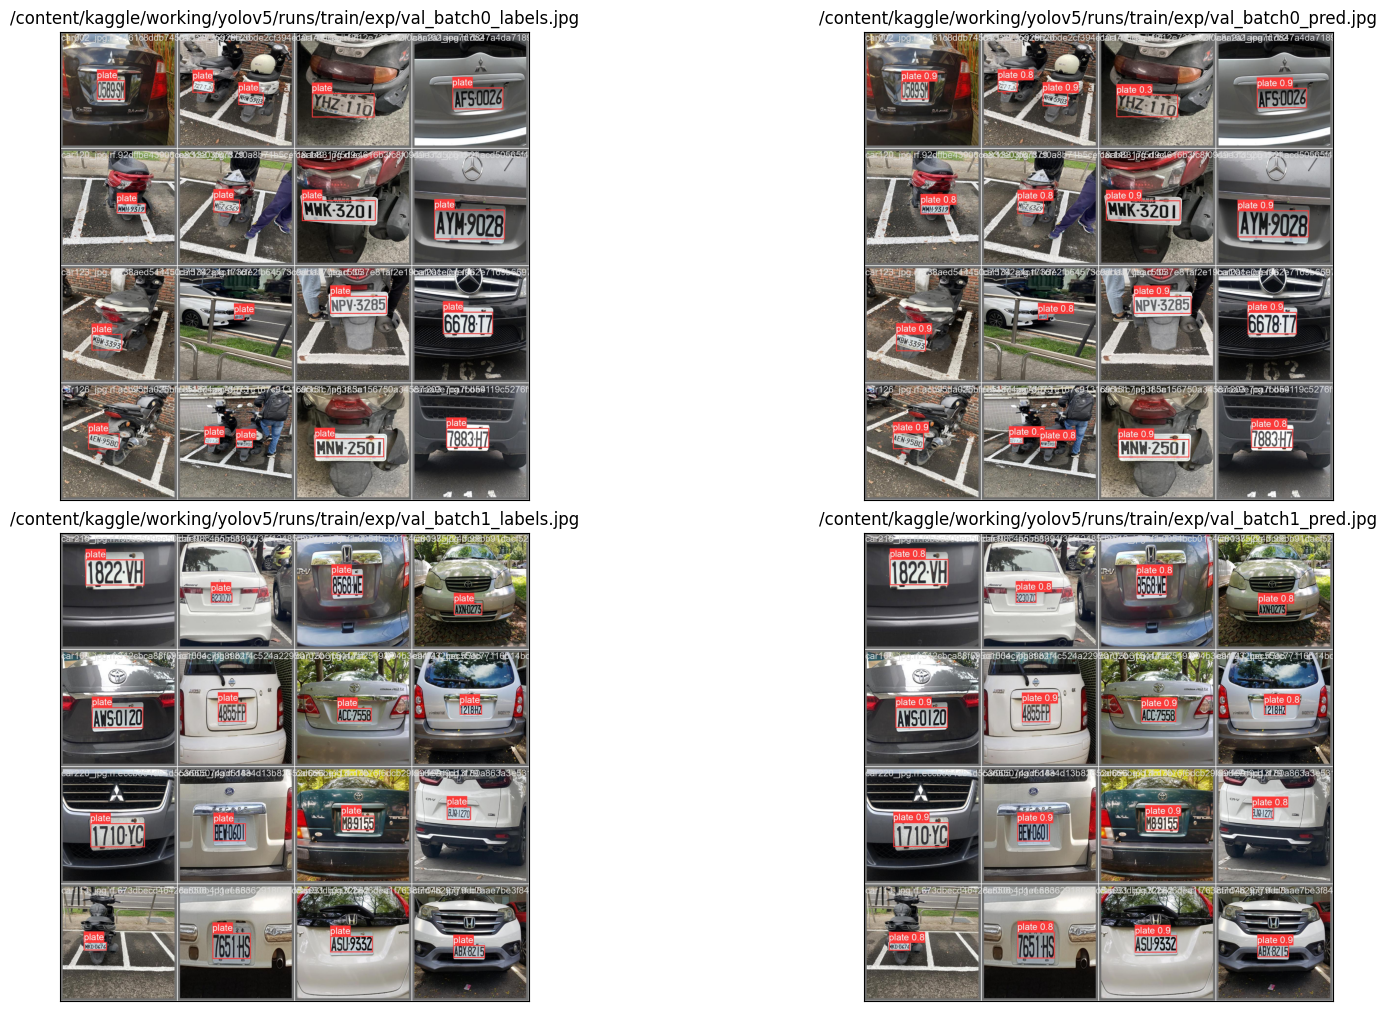

In [24]:
fig, ax = plt.subplots(2, 2, figsize = (2*8,2*5), constrained_layout = True)
for row in range(2):
    ax[row][0].imshow(plt.imread(f'/content/kaggle/working/yolov5/runs/train/exp/val_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'/content/kaggle/working/yolov5/runs/train/exp/val_batch{row}_labels.jpg', fontsize = 12)

    ax[row][1].imshow(plt.imread(f'/content/kaggle/working/yolov5/runs/train/exp/val_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'/content/kaggle/working/yolov5/runs/train/exp/val_batch{row}_pred.jpg', fontsize = 12)
plt.show()

In [25]:
import torch
from PIL import Image

CKPT_PATH = '/content/kaggle/working/yolov5/runs/train/exp/weights/best.pt'
yolov5 = torch.hub.load('/content/kaggle/working/yolov5',
                        'custom',
                        path=CKPT_PATH,
                        source='local',
                        force_reload=True)

'confidence: ' + str(yolov5.conf)

YOLOv5 🚀 v7.0-224-g6262c7f Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 


'confidence: 0.25'

In [ ]:
import pandas as pd
import numpy as np

imgs = os.listdir('/content/kaggle/working/Taiwan_plate/val')

pred_df = pd.DataFrame()
for pth in imgs:
    img = Image.open('/content/kaggle/working/Taiwan_plate/val' + pth).convert('RGB')
    img = np.asarray(img)
    pred = yolov5(img, size=640, augment=False)
    for i, row in pred.pandas().xyxy[0].iterrows():
        if row['confidence'] < yolov5.conf: break
        row['path'] = pth
        pred_df = pred_df.append(row)
pred_df = pred_df.reset_index()

In [ ]:
pred_df

In [ ]:
import pytesseract

for i, row in pred_df.iterrows():
    img = '/content/kaggle/working/Taiwan_plate/val' + row['path']
    img = Image.open(img).convert('RGB')
    img = np.asarray(img)
    img_cropped = img[int(row['ymin']):int(row['ymax']), int(row['xmin']):int(row['xmax'])]
    text = pytesseract.image_to_string(img_cropped)
    pred_df.loc[i, 'text_detected'] = text

In [ ]:
pred_df